In [3]:
## Training models for prediction sequences
## Creating windowed data
## value to predict at time t is the label and then a number of values before that time t would act as the features

import tensorflow as tf

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

for window in dataset:
  print(window.numpy())

## These are the features, with the labels being the last value

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [4]:
dataset = tf.data.Dataset.range(20)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x,y in dataset:
  print(x.numpy(), y.numpy())

# These are the features along with their labels

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]
[6 7 8 9] [10]
[ 7  8  9 10] [11]
[ 8  9 10 11] [12]
[ 9 10 11 12] [13]
[10 11 12 13] [14]
[11 12 13 14] [15]
[12 13 14 15] [16]
[13 14 15 16] [17]
[14 15 16 17] [18]
[15 16 17 18] [19]


In [5]:
## We will now shuffle the data and batch them

dataset = tf.data.Dataset.range(20)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[ 9 10 11 12]
 [ 4  5  6  7]]
y =  [[13]
 [ 8]]
x =  [[11 12 13 14]
 [ 6  7  8  9]]
y =  [[15]
 [10]]
x =  [[10 11 12 13]
 [ 5  6  7  8]]
y =  [[14]
 [ 9]]
x =  [[ 8  9 10 11]
 [12 13 14 15]]
y =  [[12]
 [16]]
x =  [[3 4 5 6]
 [2 3 4 5]]
y =  [[7]
 [6]]
x =  [[ 1  2  3  4]
 [14 15 16 17]]
y =  [[ 5]
 [18]]
x =  [[ 0  1  2  3]
 [ 7  8  9 10]]
y =  [[ 4]
 [11]]
x =  [[13 14 15 16]
 [15 16 17 18]]
y =  [[17]
 [19]]


In [6]:
import numpy as np

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [7]:
## Function to create windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [9]:
## Creating the training set and the validation set

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
    print(feature)
    print(label)


tf.Tensor(
[[74.36482  60.502842 76.68438  68.31821  67.04559  64.19138  61.049683
  73.51203  69.83512  63.09121  63.138268 68.00752  78.10447  68.53446
  62.389908 68.75025  68.68882  56.641605 69.928314 69.118996]], shape=(1, 20), dtype=float32)
tf.Tensor([73.828705], shape=(1,), dtype=float32)


In [10]:
## Training a DNN to fit to the sequence data
from tensorflow import keras

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = keras.Sequential([
    keras.Input(shape=(window_size,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(
    learning_rate=1e-6,
    momentum=0.9))

model.fit(dataset, epochs = 100)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 101.7813
Epoch 2/100
39/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.2407

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.7330
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 52.0214
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.8953
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.0318
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 51.4563
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93.2188
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.0099
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.2303
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 45.3309
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.0459
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.9521
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.8371
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.9308
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.0490
Epoch 16/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 39.17

In [11]:
# Features
feature = series[1000:1020]
# label
label = series[1020]

print("Feature:", end = '')
print(feature)
print("\nPredicted:", end = '')
print(model.predict(feature[np.newaxis]))
print("\nActual:", end = '')
print(label)


Feature:[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[104.425674]]

Actual:106.258606


In [12]:
def plot_series(time, series, format="-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

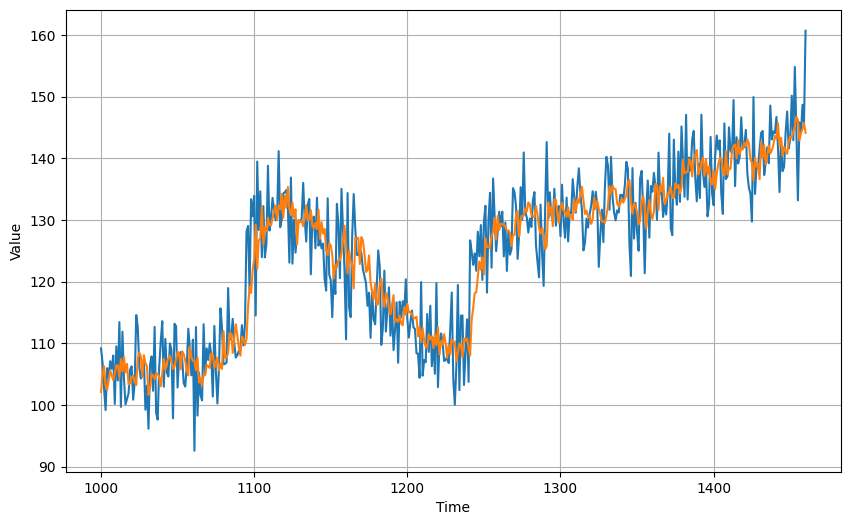

In [13]:
import matplotlib.pyplot as plt

forecast = []

for t in range(len(series) - window_size):
  forecast.append(model.predict(series[t:t+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)


In [14]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae(x_valid, results).numpy()

np.float32(4.4821887)

In [15]:
## Tuning the learning rate

model = keras.Sequential([
    keras.Input(shape=(window_size,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
# Learning rate starts at 1e-8 then after every epoch it increases a little

# Now we can specify the callback in model.fit
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)



(np.float64(1e-08), np.float64(0.001), np.float64(0.0), np.float64(1000.0))

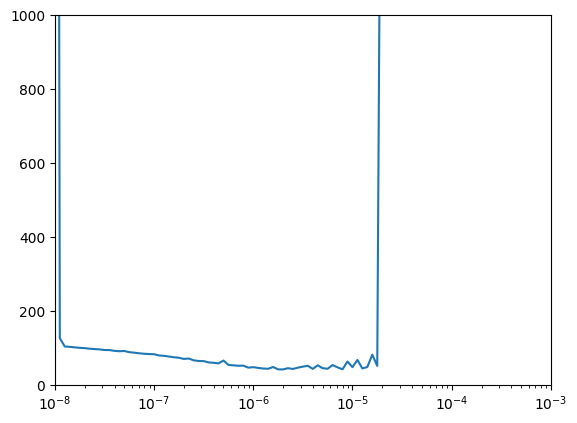

In [16]:
## Plot the learning rates against the lost to find the lr with the lowest loss

lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 1000])


In [17]:
## From the plot, 1e-5 seems to be the best lr
model = keras.Sequential([
    keras.Input(shape=(window_size,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse",optimizer=tf.keras.optimizers.SGD(
    learning_rate=1e-5,
    momentum=0.9))

model.fit(dataset, epochs = 100)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6301.7627
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6661.4990
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6321.7495
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5810.6689
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4644.5771
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2555.5518
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1352.5912
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1300.0215
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1385.1234
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1309.6611
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1377.3214
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1317.3666
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1353.0349
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1267.1992
Epoch 15/100
46/46 ━━━━━━━━━━

In [18]:
forecast = []

for t in range(len(series) - window_size):
  forecast.append(model.predict(series[t:t+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

mae = tf.keras.metrics.MeanAbsoluteError()
mae(x_valid, results).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

np.float32(42.58795)

In [19]:
## It performed worse, wow

In [20]:
## Hyperparameter tuning with keras

import keras_tuner as kt

# Function to build model based onmultiple parameters

def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      units=hp.Int("units", min_value=8, max_value=12, step=2),
      activation=hp.Choice("activation", values=["relu", "tanh"]),
      input_shape=(window_size,)
  ))
  model.add(keras.layers.Dense(8,
                               activation=hp.Choice("activation", values=["relu", "tanh"])))
  model.add(keras.layers.Dense(1))
  optimizer = keras.optimizers.SGD(
        learning_rate=1e-5,
        momentum=hp.Choice("momentum", values=[0.7, 0.5, 0.3])
    )
  model.compile(
        loss="mse",
        optimizer=optimizer
    )
  return model

## define the tuner with the build model function
tuner = kt.RandomSearch(
    build_model,
    objective="loss",
    max_trials=150,
    executions_per_trial=3,
    directory="my_dir",
    project_name="first"
)

tuner.search(dataset, epochs=100, verbose=1)



Trial 18 Complete [00h 01m 48s]
loss: 1482.9257405598958

Best loss So Far: 33.9195810953776
Total elapsed time: 00h 33m 48s


In [21]:
## Summary of the results from the tuner
tuner.results_summary()


Results summary
Results in my_dir/first
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 010 summary
Hyperparameters:
units: 12
activation: relu
momentum: 0.5
Score: 33.9195810953776

Trial 003 summary
Hyperparameters:
units: 12
activation: relu
momentum: 0.7
Score: 34.18736139933268

Trial 005 summary
Hyperparameters:
units: 12
activation: relu
momentum: 0.3
Score: 34.43070602416992

Trial 016 summary
Hyperparameters:
units: 8
activation: relu
momentum: 0.5
Score: 34.49957402547201

Trial 008 summary
Hyperparameters:
units: 10
activation: relu
momentum: 0.5
Score: 34.78708521525065

Trial 002 summary
Hyperparameters:
units: 10
activation: relu
momentum: 0.3
Score: 35.29408518473307

Trial 015 summary
Hyperparameters:
units: 10
activation: relu
momentum: 0.7
Score: 510.2644513448079

Trial 017 summary
Hyperparameters:
units: 8
activation: tanh
momentum: 0.7
Score: 1482.9257405598958

Trial 011 summary
Hyperparameters:
units: 10
activation: tanh
momentum: 0.7
Score:

In [22]:
## Picking out the best model
best_models = tuner.get_best_models(num_models=1)
best_model = best_models[0]


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
## building the best model again from scratch
model = keras.Sequential([
    keras.layers.Dense(12, activation="relu", input_shape=(window_size,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(
    learning_rate=1e-5,
    momentum=0.5
)

model.compile(loss="mse", optimizer=optimizer)

history = model.fit(dataset, epochs=100, verbose=1)


Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1614.9633
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.2472
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68.0045
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.7082
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.7346
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 109.7780
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.8880
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.5823
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.2586
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.8314
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59.2796
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.6553
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.7072
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.8136
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

In [27]:
forecast = []

for t in range(len(series) - window_size):
  forecast.append(model.predict(series[t:t+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

mae = tf.keras.metrics.MeanAbsoluteError()
mae(x_valid, results).numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

np.float32(16.044935)

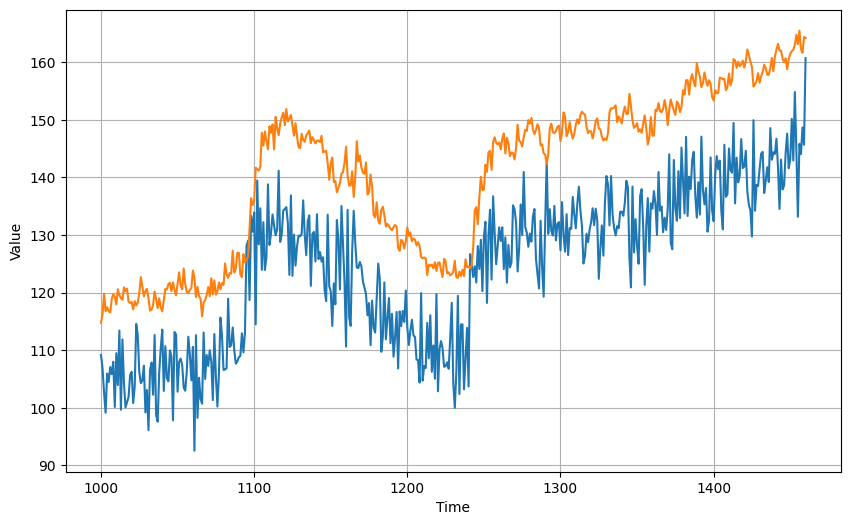

In [28]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)